In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import random
import time
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
device = torch.device("cuda")
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")
from transformers import BertTokenizer,AutoModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from torch.optim import lr_scheduler
from collections import defaultdict
import nlpaug.augmenter.word as naw
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [2]:
#read the dataset
df = pd.read_csv("datasets/processed_data.csv")
df['sentiment'] = df['sentiment'].str.lower()
df['sentiment'].value_counts()

sentiment
neutral     3976
positive    1807
negative    1509
Name: count, dtype: int64

In [3]:
#FILTER positive and negative samples
positive_samples = df[df['sentiment'] == 'positive']
negative_samples = df[df['sentiment'] == 'negative']
#filter samples from neutral sentiment (1900) so doesn't have bias towards neutral
neutral_samples = df[df['sentiment'] == 'neutral'].head(1900)

#concatenate all samples back to the original dataframe
df = pd.concat([positive_samples, negative_samples, neutral_samples], ignore_index=True)
df['sentiment'].value_counts()

sentiment
neutral     1900
positive    1807
negative    1509
Name: count, dtype: int64

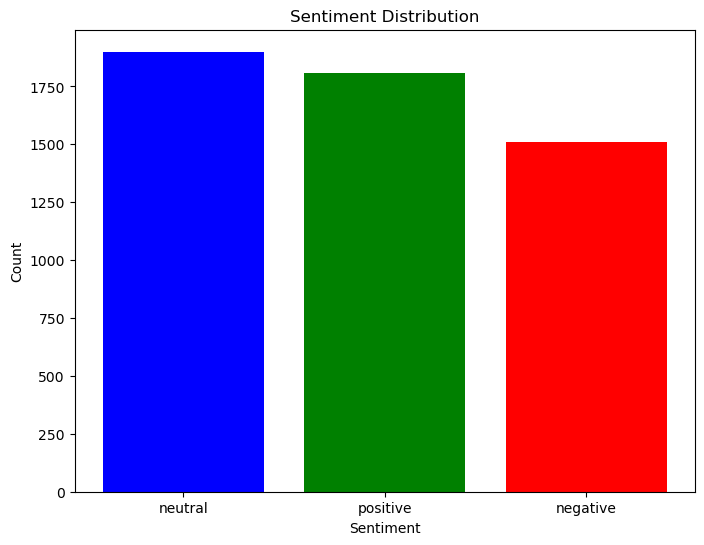

In [4]:
#Sentiment data
sentiment_data = {
    'neutral': 1900,
    'positive': 1807,
    'negative': 1509
}

#Extracting labels and counts
labels = list(sentiment_data.keys())
counts = list(sentiment_data.values())

#Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['blue', 'green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

In [5]:
sentiment_mapping = {'positive':2,'negative':1,'neutral':0}

df['sentiment'] = df['sentiment'].map(sentiment_mapping)
#converts string format to numerical form for classification, necessary for PyTorch and BERT

In [6]:
X = df.cleaned_text.values
y = df.sentiment.values

#split for training,testing and validation
X_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=40,shuffle=True)

#split for testing and validation purpose
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=40,shuffle=True)
#so model can be tested on its performance on unseen data

In [7]:
#Verify the shapes of the datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", x_test.shape, y_test.shape)
print("Validation dataset shape:", x_val.shape, y_val.shape)
print("\n")

unique_labels_train, counts_train = np.unique(y_train, return_counts=True)
print("Training set label counts:")
for label, count in zip(unique_labels_train, counts_train):
    print(f"{label}: {count}")
print("\n")

unique_labels_val, counts_val = np.unique(y_test, return_counts=True)
print("Test set label counts:")
for label, count in zip(unique_labels_val, counts_val):
    print(f"{label}: {count}")
print("\n")
#Print category labels and their counts in y_test
unique_labels_val, counts_val = np.unique(y_val, return_counts=True)
print("\nValidation set label counts:")
for label, count in zip(unique_labels_val, counts_val):
    print(f"{label}: {count}")

Training set shape: (4172,) (4172,)
Test set shape: (522,) (522,)
Validation dataset shape: (522,) (522,)


Training set label counts:
0: 1513
1: 1219
2: 1440


Test set label counts:
0: 186
1: 149
2: 187



Validation set label counts:
0: 201
1: 141
2: 180


# Pre_processing Train, Test and Validation data for model training

In [8]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

#import transformers

No GPU available, using the CPU instead.


# Bert Tokenizer

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = AutoModel.from_pretrained('bert-base-uncased')
#Initializes the tokenizer for BERT
#Prepares the input data by tokenizing text so BERT can understand.
#Tokenization converts text into tokens/indices that represent BERT's vocabulary.

In [11]:
#train_tokenized
class TextTokenizer:
    def __init__(self, max_len,tokenizer):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def tokenize_texts(self, texts):
        tokenized_texts = [self.tokenizer.encode_plus(
            text=text,
            max_length=self.max_len,
            add_special_tokens=True,
            truncation=True,
            pad_to_max_length=True
        ) for text in texts]

        input_ids = torch.tensor([tokenized['input_ids'] for tokenized in tokenized_texts],dtype=torch.long)
        attention_mask = torch.tensor([tokenized['attention_mask'] for tokenized in tokenized_texts],dtype=torch.long)
            
        return input_ids, attention_mask

In [12]:
def create_dataloader(input_ids, attention_mask,labels, batch_size,sampler):
    
    #Wrap tensors into a TensorDataset
    dataset = TensorDataset(input_ids, attention_mask, torch.tensor(labels))
    #Sampler for sampling the data during training
    if sampler == 'RandomSampler':
        sampler = RandomSampler(dataset)
    elif sampler == 'SequentialSampler':
        sampler = SequentialSampler(dataset)
    #DataLoader for the dataset
    dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)
    
    return dataloader

'''Prepares batches of data for 
training and evaluation, 
PyTorch’s DataLoaders streamline feeding data into the model.
'''

# Bert Architrecture

In [13]:
class BERT_architecture(nn.Module):
#Defines the BERT model architecture for sentiment analysis. 
  def __init__(self, bert):
    super(BERT_architecture, self).__init__()
    self.bert = bert 
    #Initial model finetuned by addition of 2 more layers: the fully connected layer and dropout layer
    self.fc1 = nn.Linear(self.bert.config.hidden_size, 512)
    #self.fc1 is the fully connected layer , 512 is the hidden output neuron 
    self.drop = nn.Dropout(p=0.25)
    #self.drop is the dropout layer where  25% of the hidden inputs dropped
    self.out = nn.Linear(512, 3)
    #The last layer is for the prediciton - the output layer 
    for param in self.bert.parameters():
            param.requires_grad = False
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask, return_dict=False)
    
    outputs = self.fc1(pooled_output)
    outputs = self.drop(outputs)
    return self.out(outputs)


In [14]:
def initialize_model(train_dataloader,epochs):
    
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    #pass the pre-trained BERT to define architecture

    bert_classifier = BERT_architecture(bert)
   
    #push the model
    bert_classifier = bert_classifier.to(device)

    #creating the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=1e-3,    #Default learning rate
                      correct_bias=False   
                      )

    #total number of training steps
    total_steps = len(train_dataloader) * epochs

    #set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, #Default value
                                                num_training_steps=total_steps)

    return bert_classifier, optimizer, scheduler

In [15]:
def loss_function(outputs, targets):
    return nn.CrossEntropyLoss()(outputs, targets)
output_model = './UI/model/bertModel.pt'
def save(model):
    #save
    torch.save(model.state_dict(), output_model)

In [16]:
def train_function(model, train_dataloader, val_dataloader, epochs):
    #for training the BERT CLASSIFIER MODEL
    history = defaultdict(list)
    
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    best_accuracy = 0
    
    #BEGIN training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        #print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        #measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        #reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        #putting the model into the training mode
        model.train()

        #for each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            #load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            #zero out any previously calculated gradients (eg make model forget everything it learned before, because i will re-tune the model)
            model.zero_grad()

            #perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)         

            #compute loss and accumulate the loss values
            loss = loss_function(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            #perform a backward pass to calculate gradients (if don't see the proper accuracy/expected result it goes backward and starts training again)
            loss.backward()

            #clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            #update parameters and the learning rate
            optimizer.step()
            scheduler.step()
            
            
            #optimizer.zero_grad()
            #print the loss values and time elapsed for every 20 batches
            if (step % 30 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                #calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                #print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                #reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        #calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        #after the completion of each training epoch, measure the model's performance
        # on the validation set.
        val_loss, val_accuracy = evaluate(model, val_dataloader)
        train_loss, train_accuracy = evaluate(model, train_dataloader)
        
        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)

        # If we beat prev performance
        if val_accuracy > best_accuracy:
            save(model)
            best_accuracy = val_accuracy

        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
            
        print(f"{epoch_i + 1:^7} | {'-':^7} | {train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        print("-"*70)
    print("\n")
    
    print("Training complete!")
    
    return history

In [17]:
def evaluate(model, val_dataloader):

    #Measure model's performance on valid. set after each training epoch
    model.eval()

    val_accuracy = []
    val_loss = []

    #for each batch in the validation set
    for batch in val_dataloader:
        
        #load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        #compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        #compute loss
        loss = loss_function(logits, b_labels)
        val_loss.append(loss.item())

        #get predictions
        preds = torch.argmax(logits, dim=1).flatten()

        #calculate accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean()
        val_accuracy.append(accuracy)

    #calculate average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

# Prepare Data for tensors

In [18]:
def set_seed(seed_value=42):
    
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

max_len = 116 #Tried 90, 116 and 315

In [19]:
#creating an instance of the TextTokenizer class
text_tokenizer = TextTokenizer(max_len,tokenizer)

#TOKENIZING the training data
train_seq, train_mask = text_tokenizer.tokenize_texts(X_train.tolist())
val_seq, val_mask = text_tokenizer.tokenize_texts(x_val.tolist())     
test_seq, test_mask = text_tokenizer.tokenize_texts(x_test.tolist())

#convert the datatype to torch.tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

batch_size=16
train_dataloader = create_dataloader(train_seq, train_mask, train_labels, batch_size,sampler = 'RandomSampler')
val_dataloader  =  create_dataloader(val_seq, val_mask, val_labels, batch_size,sampler = 'SequentialSampler')

In [20]:
epochs = 10

In [21]:
set_seed(100)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(train_dataloader,epochs)

In [22]:
%%time
history= train_function(bert_classifier, train_dataloader, val_dataloader, epochs)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   30    |   3.260342   |     -      |     -     |   22.70  
   1    |   60    |   1.691440   |     -      |     -     |   21.79  
   1    |   90    |   1.678503   |     -      |     -     |   21.33  
   1    |   120   |   1.257627   |     -      |     -     |   21.28  
   1    |   150   |   1.031779   |     -      |     -     |   21.21  
   1    |   180   |   1.016317   |     -      |     -     |   25.62  
   1    |   210   |   1.027526   |     -      |     -     |   21.44  
   1    |   240   |   1.015302   |     -      |     -     |   22.00  
   1    |   260   |   0.973866   |     -      |     -     |   14.05  
----------------------------------------------------------------------
   1    |    -    |   1.020905   |  1.000209  |   0.55    |  333.60  
---------------------------------------------------------------------

(0.0, 1.0)

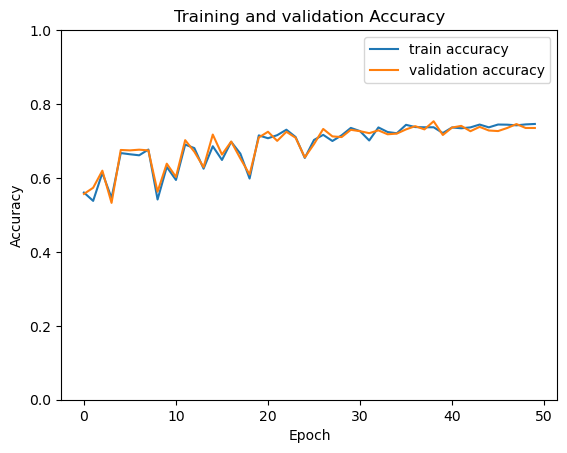

In [ ]:
#plot of the training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training and validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

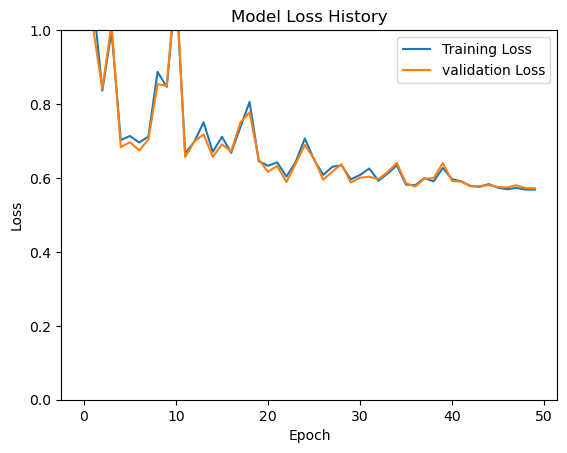

In [ ]:
#plot of the training and validation accuracy
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='validation Loss')

plt.title('Model Loss History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Model testing

In [ ]:
#creation of the DataLoader for the test set
test_dataset = TensorDataset(test_seq, test_mask)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16) 

In [ ]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    #putting the model into the evaluation model & the dropout layers are disabled
    model.eval()

    all_logits = []

    # For each batch in the test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    # Cpu() method transfers tensor from current device to cpu - neccessary for operation not supported on GPU
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
probs = bert_predict(bert_classifier, test_dataloader)
pred = np.argmax(probs, axis = 1)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       186
           1       0.74      0.81      0.77       149
           2       0.69      0.65      0.67       187

    accuracy                           0.75       522
   macro avg       0.75      0.75      0.75       522
weighted avg       0.75      0.75      0.75       522



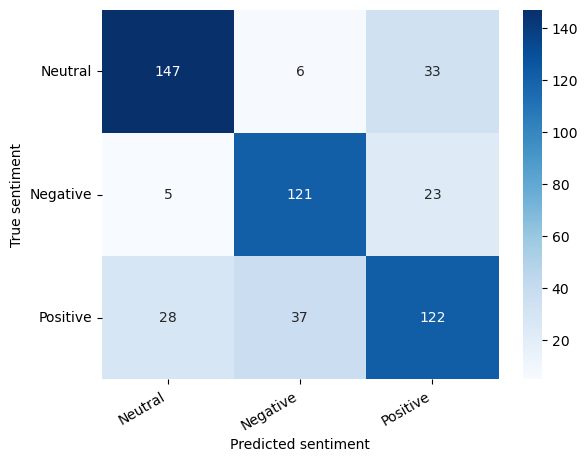

In [ ]:
def show_confusion_matrix(confusion_matrix):
    labels = ['Neutral', 'Negative', 'Positive']
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(labels, rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(labels, rotation=30, ha='right')
    plt.ylabel('Actual sentiment')
    plt.xlabel('Predicted sentiment')

#cm is the confusion matrix
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)
plt.show()

In [ ]:
#for GENERATING MODELS
import os
#Save the BERT model and tokenizer
model_path = "./UI/model"
os.makedirs(model_path, exist_ok=True)
tokenizer.save_pretrained(model_path)
bert.save_pretrained(model_path)

References:
[1] Joshi, P., 2020. Fine-Tuning-BERT. [Online] Available at: https://github.com/prateekjoshi565 [Accessed 1 November 2024]. 

[2] Valkov, V., 2020. Sentiment Analysis with BERT. [Online] Available at: https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/08.sentiment-analysis-with-bert.ipynb [Accessed 2 November 2024].
